# INIT

In [193]:
def dict_factory(cursor, row):
    fields = [column[0] for column in cursor.description]
    return {key: value for key, value in zip(fields, row)}

In [194]:
import sqlite3
import pandas as pd

import seaborn as sns  #for data visualization operations
import matplotlib.pyplot as plt  #for data visualization operations

In [195]:
# to show all rows and columns 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [196]:
def run(sql):
    r = cur.execute(sql)
    return(r.fetchall())

## DB Connect

In [197]:
# set plt parameters
plt.style.use('seaborn')

con = sqlite3.connect("../M1P5S1-SQL/superstore.db")
con.row_factory = dict_factory
cur = con.cursor()

## DB Query

In [198]:
data = (pd.DataFrame(run("""
    SELECT
        Customer_ID,
        Customer_Name,
        Segment,
        sum(Sales) As Amount,
        count(distinct(Row_ID)) AS Orders,
        count(distinct(Cart_ID)) AS Purchases
    FROM Purchase P
    LEFT JOIN Customer CU ON P.Customer_ID = CU.ID
    LEFT JOIN Cart C ON P.Cart_ID = C.ID
    GROUP BY Customer_ID
    ORDER BY Orders DESC
""")))
display(data.head())

Customer_ID    Customer_Name      Segment       Amount  Orders  Purchases
0          553  Muhammed Yedwab    Corporate  29642.66118     108         39
1          717      Steven Ward    Corporate  25668.48600     106         38
2          590  Patrick O'Brill     Consumer  26707.45620     102         45
3          295       Gary Hwang     Consumer  24625.59300     102         41
4           89      Bill Eplett  Home Office  28479.16740     102         42

In [199]:
average_distance = (pd.DataFrame(run("""
SELECT 
    Customer_ID, 
    AVG(days_between_orders) AS Frequency,
    julianday('2014-12-31') - julianday(MAX(order_date)) AS Recency
FROM (
    SELECT 
        Customer_ID, 
        order_date,
        julianday(order_date) - julianday(LAG(order_date) OVER (PARTITION BY customer_id ORDER BY order_date)) AS days_between_orders
    FROM Purchase
) AS subquery
GROUP BY Customer_ID
ORDER BY Frequency ASC
""")))


In [200]:
data = pd.merge(data, average_distance, on="Customer_ID", how="outer").drop_duplicates()

## DB Disconnect

In [201]:
cur.close()
con.close()

# Clustering
When working with sales data, a common thing to do is to understand the customers' buying patterns using 3 parameters: 
* Monetary (amount of money spent)
* Frequency (how frequently the customer bought something) 
* Recency (how many days has passed from today to their last purchase).

These parameters are not given to us; we will have to calculate them.

First, we will create a new DataFrame by grouping the customers based on their ID and summing the Sales column:

```
data_monetary = data.groupby('Customer ID')['Sales'].sum()
data_monetary = data_monetary.reset_index()
data_monetary.head()
```

Do the same with Frequency (How many unique Order IDs are there per customer?) and the Recency (Calculate it from the last order date in the dataset) and then merge all the 3 DataFrames.

You will end up with a DataFrame similar to the one below:</br>
<img src="mon-freq-rec.jpg"> 

In [202]:
data["_filter"] = 0

In [203]:
data.head()

Customer_ID    Customer_Name      Segment       Amount  Orders  Purchases  \
0          553  Muhammed Yedwab    Corporate  29642.66118     108         39   
1          717      Steven Ward    Corporate  25668.48600     106         38   
2          590  Patrick O'Brill     Consumer  26707.45620     102         45   
3          295       Gary Hwang     Consumer  24625.59300     102         41   
4           89      Bill Eplett  Home Office  28479.16740     102         42   

   Frequency  Recency  _filter  
0  38.078947      0.0        0  
1  34.945946     15.0        0  
2  32.522727      4.0        0  
3  35.450000     18.0        0  
4  32.268293     35.0        0

### Show Distribution of data

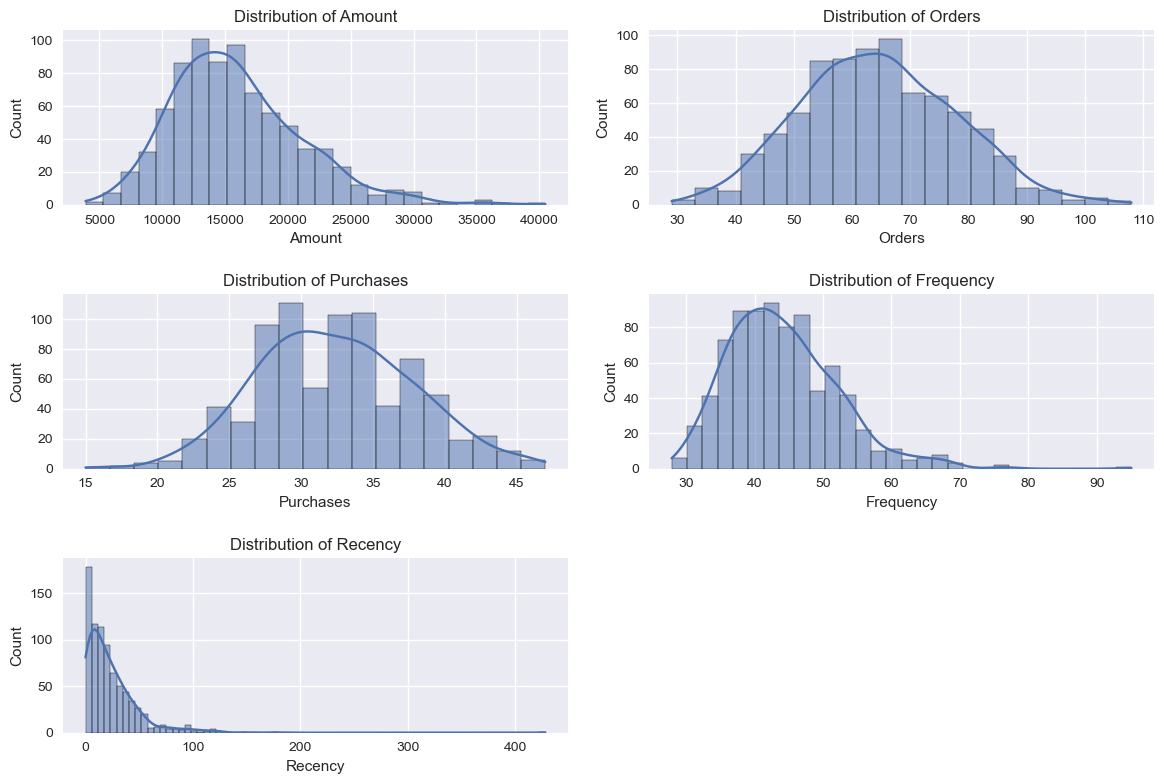

In [204]:
plt.figure(figsize=(12,8))
i = 0
for col in data:
    if (col != "Customer_ID") & (not col.startswith("_")) & ( data[col].dtype in ['int64', 'float64']):
        plt.subplot(3,2,i+1)
        plt.tight_layout(pad=2,h_pad=2)
        plt.title(f"Distribution of {col}")
        sns.histplot(data[col],  kde=True)
        i += 1

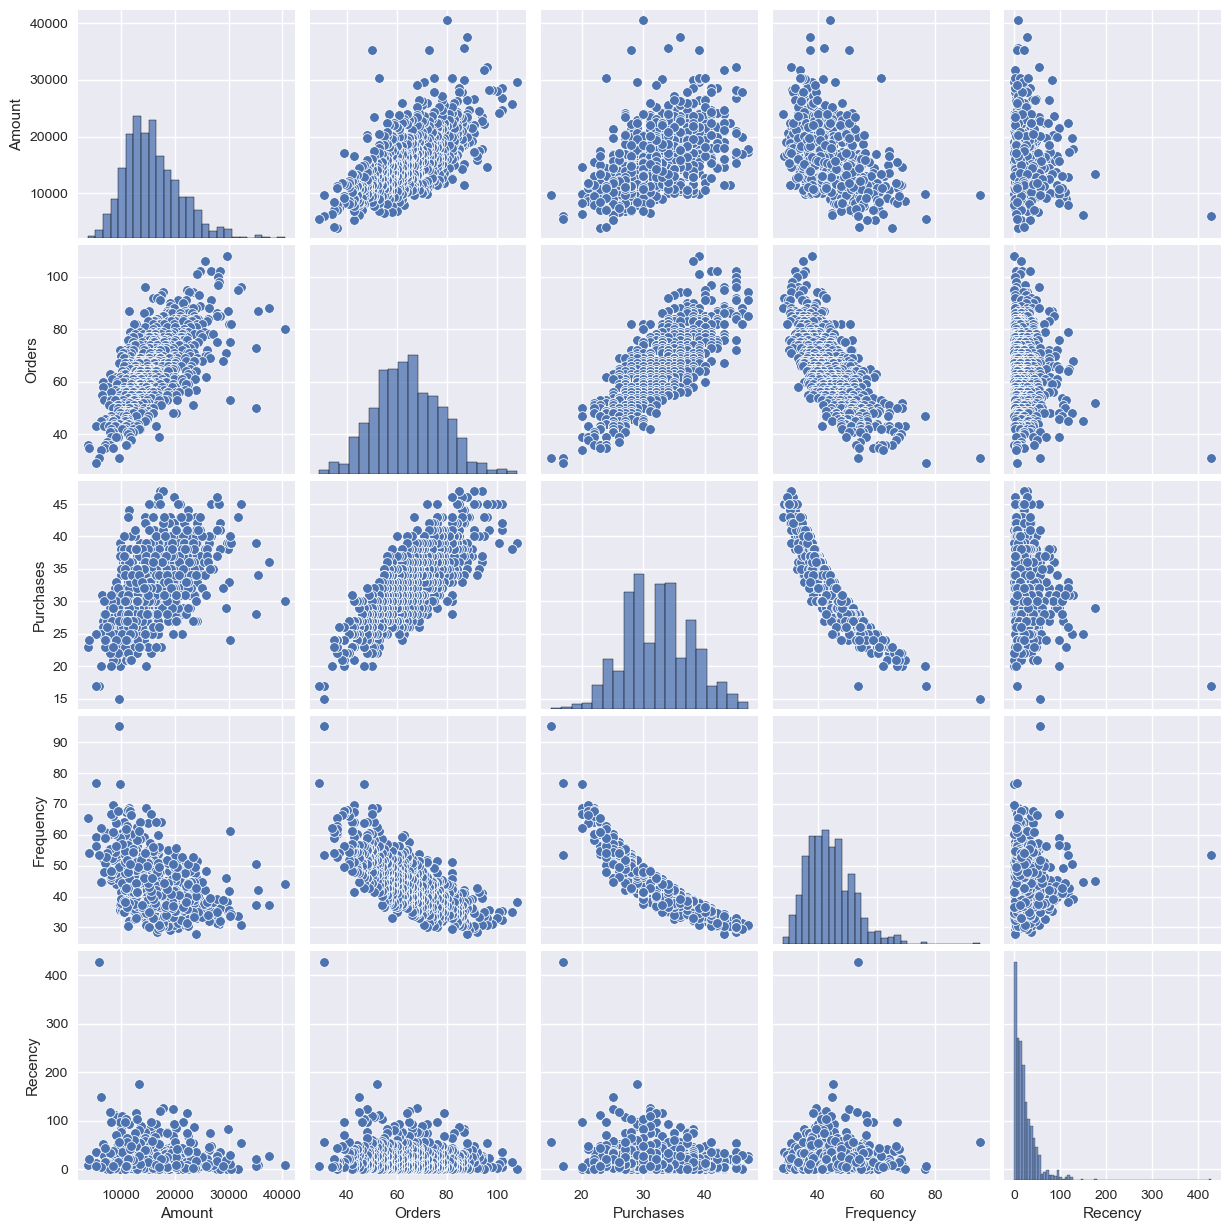

In [205]:
sns.pairplot(data[["Amount", "Orders", "Purchases", "Frequency", "Recency"]])

## Dealing with outliers
Try to visualize with a boxplot these 3 parameters: are there outliers? Because of its nature, the K-Means algorithm is susceptible to outliers. To check the consequences of having outliers when using a K-Means algorithm, read this article: Effect of outliers on K-Means algorithm using Python

Remove each feature's (statistical) outliers using the Interquartile Range (IQR is the difference between the upper quartile and the lower quartile).

### Removing outliers

In [206]:
total = 0
for col in data:
    if (col != "Customer_ID") & (not col.startswith("_")) & ( data[col].dtype in ['int64', 'float64']):
        Q1 = data[[col]].quantile(0.25)
        Q3 = data[[col]].quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[((data[[col]] < (Q1 - 1.5 * IQR)) | ( data[[col]] > (Q3 + 1.5 * IQR))).any(axis=1)]
        data.loc[((data[[col]] < (Q1 - 1.5 * IQR)) |(data[[col]] > (Q3 + 1.5 * IQR))).any(axis=1), '_filter'] = 1
        if ( len(outliers) ):
            total += len(outliers)
            print(f"Removed {len(outliers)} entries due to {col} (Mean: {round(data[col].mean(), 2)}/Q1: {round(float(Q1), 2)}/Q3: {round(float(Q3), 2)}/IQR: {round(float(IQR), 2)})")
            display(outliers)
print(f"A total of {total} datasets were removed")

Removed 16 entries due to Amount (Mean: 15902.52/Q1: 12242.61/Q3: 18770.8/IQR: 6528.19)


Customer_ID       Customer_Name      Segment       Amount  Orders  \
0            553     Muhammed Yedwab    Corporate  29642.66118     108   
10            74        Bart Watters    Corporate  32310.44650      96   
11           559    Natalie Fritzler     Consumer  31781.25850      95   
29           732        Tamara Chand    Corporate  37457.33300      88   
34           608        Peter Fuller     Consumer  29875.99966      87   
36           314           Greg Tran     Consumer  35550.95428      87   
83           674        Sanjit Engle     Consumer  30146.33502      82   
84           603     Penelope Sewall  Home Office  30081.67540      82   
92           291        Fred Hopkins    Corporate  30400.67452      82   
103          759        Tom Ashbrook  Home Office  40488.07080      80   
183          348           Jane Waco    Corporate  30288.45030      75   
219          158  Christopher Conant     Consumer  35187.07640      73   
238          624        Raymond Buch     Consumer  29602.14260      71   
290          728        Susan Pistek     Consumer  29020.60386      68   
643          336        Hunter Lopez     Consumer  30243.56658      53   
672          688         Sean Miller  Home Office  35170.93296      50   

     Purchases  Frequency  Recency  _filter  
0           39  38.078947      0.0        0  
10          45  30.909091     54.0        0  
11          43  33.738095      1.0        0  
29          36  37.371429     27.0        0  
34          38  35.216216     83.0        0  
36          34  42.000000      8.0        0  
83          39  35.552632      9.0        0  
84          33  41.718750     20.0        0  
92          39  34.473684      1.0        0  
103         30  43.931034      8.0        0  
183         40  33.666667     12.0        0  
219         39  37.368421      6.0        0  
238         29  45.928571     20.0        0  
290         32  38.838710      6.0        0  
643         24  61.304348     30.0        0  
672         28  50.481481     21.0        0

Removed 2 entries due to Orders (Mean: 64.52/Q1: 55.0/Q3: 74.0/IQR: 19.0)


Customer_ID    Customer_Name    Segment       Amount  Orders  Purchases  \
0          553  Muhammed Yedwab  Corporate  29642.66118     108         39   
1          717      Steven Ward  Corporate  25668.48600     106         38   

   Frequency  Recency  _filter  
0  38.078947      0.0        1  
1  34.945946     15.0        0

Removed 1 entries due to Purchases (Mean: 32.39/Q1: 28.0/Q3: 36.0/IQR: 8.0)


Customer_ID Customer_Name    Segment     Amount  Orders  Purchases  \
793          198   Darren Budd  Corporate  9679.2392      31         15   

     Frequency  Recency  _filter  
793  95.071429     57.0        0

Removed 15 entries due to Frequency (Mean: 44.12/Q1: 38.21/Q3: 48.81/IQR: 10.61)


Customer_ID      Customer_Name      Segment       Amount  Orders  \
655          209     David Flashing     Consumer  11542.03590      52   
673          678         Sarah Bern     Consumer  14598.17400      50   
678          471    Liz MacKendrick     Consumer  15529.85300      50   
721          607       Peter Bühler     Consumer   9895.98900      47   
756          415       Kalyca Meade    Corporate   8645.91460      43   
759          297       Gary Mitchum  Home Office  11012.07900      43   
769          727  Susan MacKendrick     Consumer   8630.47440      41   
774          788   Vivek Sundaresam     Consumer  11411.98900      40   
775          594       Paul Knutson  Home Office   8231.03756      39   
776          423   Katherine Ducich     Consumer  11693.50040      39   
777          337      Ionia McGrath     Consumer   9479.78976      39   
780          746     Thomas Brumley  Home Office  11801.84152      38   
782          789      Vivian Mathis     Consumer   3892.22700      36   
793          198        Darren Budd    Corporate   9679.23920      31   
794          530     Michael Oakman     Consumer   5460.58400      29   

     Purchases  Frequency  Recency  _filter  
655         22  68.619048      9.0        0  
673         20  68.526316      2.0        0  
678         22  66.761905      7.0        0  
721         20  76.263158      0.0        0  
756         21  69.700000      0.0        0  
759         21  67.200000     16.0        0  
769         22  66.000000     37.0        0  
774         22  68.142857     22.0        0  
775         20  66.789474     98.0        0  
776         21  67.550000     41.0        0  
777         22  67.714286     15.0        0  
780         21  66.400000     49.0        0  
782         23  65.272727      8.0        0  
793         15  95.071429     57.0        1  
794         17  76.625000      6.0        0

Removed 40 entries due to Recency (Mean: 23.37/Q1: 6.0/Q3: 33.0/IQR: 27.0)


Customer_ID      Customer_Name      Segment       Amount  Orders  \
34           608       Peter Fuller     Consumer  29875.99966      87   
39            61     Arthur Prichep     Consumer  18545.94030      87   
52           691        Seth Vernon     Consumer  23632.91948      85   
79           205      Dave Hallsten    Corporate  16192.36010      83   
110          560     Natalie Webber     Consumer  22373.56906      79   
163          503       Mathew Reese  Home Office  21571.95230      76   
227          477   Logan Haushalter     Consumer  17292.23980      72   
230          269      Erin Ashbrook    Corporate  11518.87572      72   
236          679        Sarah Brown     Consumer  22302.89772      71   
259          138        Cathy Hwang  Home Office  15668.17456      70   
268          673       Sanjit Chand     Consumer  26521.13200      69   
299          538      Michelle Tran  Home Office  17772.32190      68   
306          186    Cynthia Delaney  Home Office  14498.90250      68   
345          707   Speros Goranitis     Consumer  12944.60556      66   
349          571      Nick Zandusky  Home Office  20270.28212      66   
356          439          Ken Black    Corporate  16602.52950      66   
369          641          Rob Lucas     Consumer  17287.05048      65   
376          408         Julie Kriz  Home Office  15647.78664      65   
397          340        Ivan Liston     Consumer  12855.50176      64   
444          355  Jason Klamczynski    Corporate  17204.23132      62   
473          185    Cynthia Arntzen     Consumer  19836.36100      61   
477          784   Victoria Pisteka    Corporate  18551.22550      60   
502          698       Sheri Gordon     Consumer  13816.94730      59   
513          143   Charles Crestani     Consumer  13348.84660      59   
564          777      Trudy Schmidt     Consumer   9978.33720      56   
574          441           Ken Dana    Corporate  12554.42362      56   
616          667     Sally Matthias     Consumer  13063.96750      54   
647           26     Allen Goldenen     Consumer   8926.12160      53   
649          700    Shirley Jackson     Consumer  13384.85900      52   
665          289         Fred Chung    Corporate   9321.68964      51   
670          786     Vivek Gonzalez     Consumer  10294.77850      50   
703          642       Rob Williams    Corporate   9985.93430      48   
716          107       Brian Dahlen     Consumer   9892.30214      48   
717           32       Andrew Allen     Consumer  19759.08278      48   
724          300       Gene McClure     Consumer  11002.55562      47   
732          447      Kristina Nunn  Home Office  10715.63600      46   
738          655        Roy Collins     Consumer   7954.11330      45   
739          643     Robert Barroso    Corporate   6256.18840      45   
775          594       Paul Knutson  Home Office   8231.03756      39   
792          572     Nicole Brennan    Corporate   5935.07540      31   

     Purchases  Frequency  Recency  _filter  
34          38  35.216216     83.0        1  
39          37  38.361111     76.0        0  
52          36  38.914286     87.0        0  
79          35  39.823529     75.0        0  
110         33  40.812500    117.0        0  
163         29  41.250000     97.0        0  
227         37  36.833333     75.0        0  
230         34  39.878788     93.0        0  
236         38  35.891892     74.0        0  
259         29  45.357143     89.0        0  
268         35  39.470588     75.0        0  
299         31  39.200000    127.0        0  
306         32  43.580645     76.0        0  
345         38  36.810811     75.0        0  
349         30  42.206897     85.0        0  
356         29  45.500000     93.0        0  
369         31  42.800000    120.0        0  
376         32  41.193548     97.0        0  
397         32  38.225806    116.0        0  
444         31  45.400000     77.0        0  
473         30  41.724138     93.0        0  

A total of 74 datasets were removed


### Boxplots

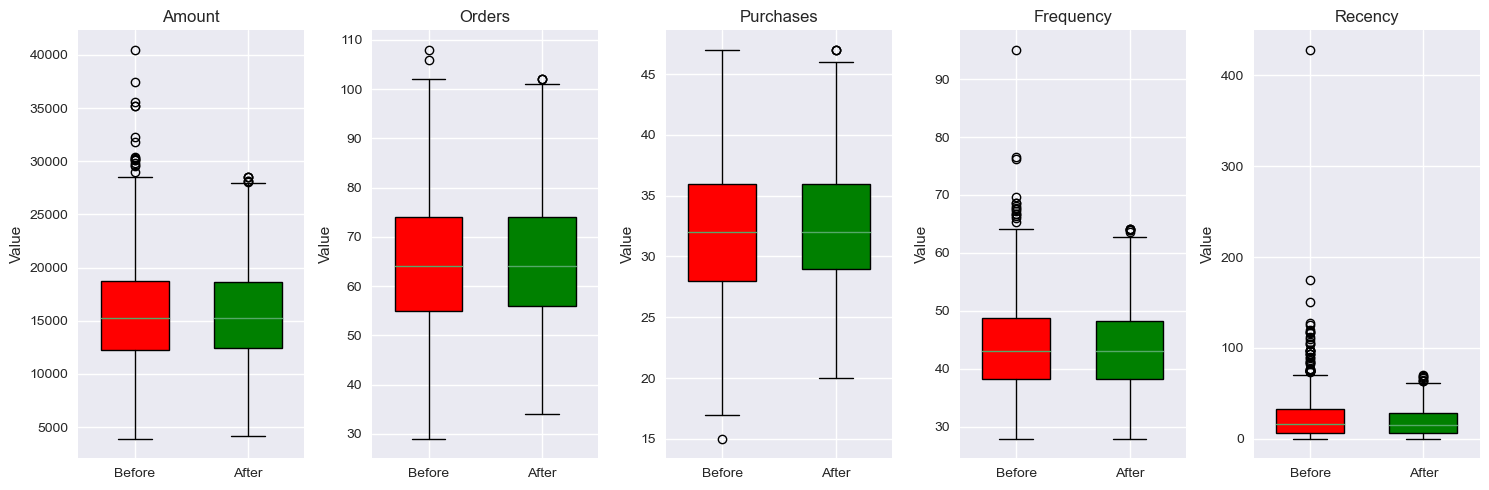

In [207]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), figsize=(15, 5))

# Generate boxplots for each column
i = 0
for col in data:
    if (col != "Customer_ID") & (not col.startswith("_")) & ( data[col].dtype in ['int64', 'float64']):
        # Before removing outliers
        axs[i].boxplot(data[col], positions=[0], widths=0.6, patch_artist=True, boxprops=dict(facecolor='red'))
        # After removing outliers
        axs[i].boxplot(data[data["_filter"] == 0][col], positions=[1], widths=0.6, patch_artist=True, boxprops=dict(facecolor='green'))

        axs[i].set_title(col)
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['Before', 'After'])
        axs[i].set_ylabel("Value")
        i += 1

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Feature scaling
Because of the nature of the algorithm, it is crucial to rescale the variables so that they have a comparable scale. There are two common ways of rescaling: Min-Max scaling Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.
```
# Rescaling the attributes
rfm_data = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_data_scaled = scaler.fit_transform(rfm_data)
rfm_data_scaled.shape

rfm_data_scaled = pd.DataFrame(rfm_data_scaled)
rfm_data_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_data_scaled.head()
```

In [208]:
data.head()

Customer_ID    Customer_Name      Segment       Amount  Orders  Purchases  \
0          553  Muhammed Yedwab    Corporate  29642.66118     108         39   
1          717      Steven Ward    Corporate  25668.48600     106         38   
2          590  Patrick O'Brill     Consumer  26707.45620     102         45   
3          295       Gary Hwang     Consumer  24625.59300     102         41   
4           89      Bill Eplett  Home Office  28479.16740     102         42   

   Frequency  Recency  _filter  
0  38.078947      0.0        1  
1  34.945946     15.0        1  
2  32.522727      4.0        0  
3  35.450000     18.0        0  
4  32.268293     35.0        0

In [209]:
from sklearn.preprocessing import StandardScaler

rfm_data = data[data['_filter'] == 0][['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_data_scaled = scaler.fit_transform(rfm_data)
rfm_data_scaled.shape

rfm_data_scaled = pd.DataFrame(rfm_data_scaled)
rfm_data_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_data_scaled.head()

Amount  Frequency   Recency
0  2.393696  -1.538803 -0.954918
1  1.940954  -1.135383 -0.070735
2  2.778989  -1.573867  1.002917
3  1.851978  -1.197399 -0.449670
4  2.693140  -1.485556 -1.081230

## Building the model
K-means clustering is one of the simplest and most popular unsupervised machine learning algorithms. The algorithm works as follows:

* First, we randomly initialize k points, called means. In this case, we will use 4 as a value.
* We categorize each item to its closest mean and update the mean's coordinates, which are the averages of the items categorized in that mean so far.
* We repeat the process for a given number of iterations, and, in the end, we have our clusters.
```
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_data_scaled)
```
```
# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())
```

In [210]:
from collections import Counter
from sklearn.cluster import KMeans

# k-means with some arbitrary k
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_data_scaled)

# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 179), (1, 272), (2, 274)]

## Finding the optimal number of clusters
As said before, we randomly decided that the number of clusters is 4. However, is it the optimal number?

There are two methods to determine the best k: the Elbow method and the Silhouette analysis.

### The Elbow Method

According to the article Elbow Method for optimal value of k in KMeans, " a fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k."

Although our first thought might be that increasing the number of parameters (k) will improve the fit of our model, we risk overfitting it. The Elbow Curve will help us identify when, if we were to add more clusters, it would only add so much more information to our model. The optimal k value will be where the average distance falls off suddenly. Which is when the curve starts to become parallel to the x-axis.
```
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_data_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)
```
</br>
<img src="elbow_curve.png"> 

In this case, we can assume that the optimal number of clusters is 3, but it needs to be clarified as the Elbow is not very prominent.

Silhouette Analysis

Another way to determine the number of clusters is by using Silhouette Analysis. According to the scikit-learn documentation, " can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually." Some people argue that the Silhouette Analysis is better than the Elbow Method.
</br>
<img src="sil-score.png"> 


* p is the mean distance to the points in the nearest cluster that the data point is not a part of.
* q is the mean intra-cluster distance to all the points in its own cluster.
* The value of the silhouette score range lies between -1 to 1.
* A score closer to 1 indicates that the data point is very similar to other data points in the cluster.
* A score of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.
```
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_data_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_data_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
```
Based on the information given here and some research online, determine whether k=3 is the right choice.

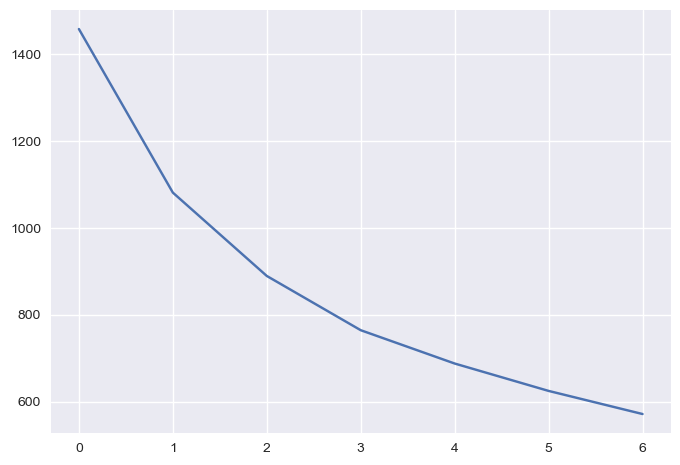

In [211]:
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_data_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)

In [212]:
from sklearn.metrics import silhouette_score

# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_data_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_data_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.29076974047767334
For n_clusters=3, the silhouette score is 0.3042029603631427
For n_clusters=4, the silhouette score is 0.2719181784565154
For n_clusters=5, the silhouette score is 0.270065368065617
For n_clusters=6, the silhouette score is 0.2632653809576548
For n_clusters=7, the silhouette score is 0.2587435701533909
For n_clusters=8, the silhouette score is 0.2550149536805069



## Train your model
Now train your final model with the appropriate value of k.

Then, assign the resulting labels to the Monetary, Frequency, and Recency DataFrame (before scaling).
```
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()
And then try to visualize the results:

# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)
```
Now that you've gone through these basic steps, you can draw conclusions about the behavior of the three groups.

In [213]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(rfm_data_scaled)

# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 392), (1, 333)]

In [214]:
df = data[data['_filter']==0]

# assign the label
df['Cluster_Id'] = kmeans.labels_
df.head()

C:\Users\Coding\AppData\Local\Temp\ipykernel_3432\3913962229.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Customer_ID    Customer_Name      Segment       Amount  Orders  Purchases  \
2          590  Patrick O'Brill     Consumer  26707.45620     102         45   
3          295       Gary Hwang     Consumer  24625.59300     102         41   
4           89      Bill Eplett  Home Office  28479.16740     102         42   
5          323     Harry Greene     Consumer  24216.45252     101         39   
6          264     Eric Murdock     Consumer  28084.40348     100         45   

   Frequency  Recency  _filter  Cluster_Id  
2  32.522727      4.0        0           1  
3  35.450000     18.0        0           1  
4  32.268293     35.0        0           1  
5  35.000000     12.0        0           1  
6  32.909091      2.0        0           1

<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

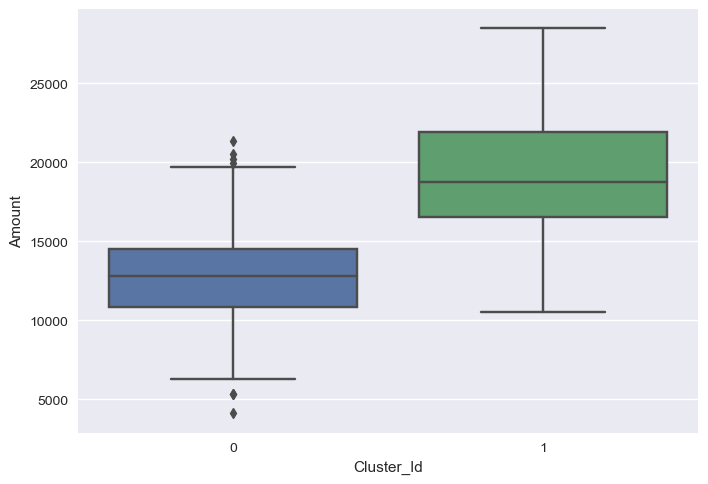

In [215]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Amount', data=df)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

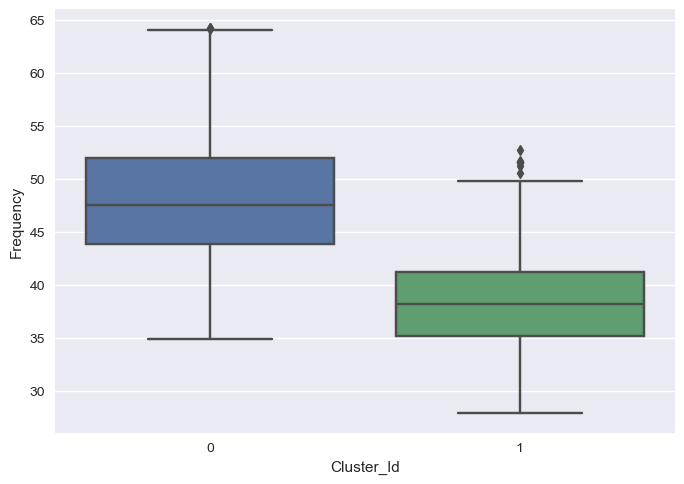

In [216]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=df)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

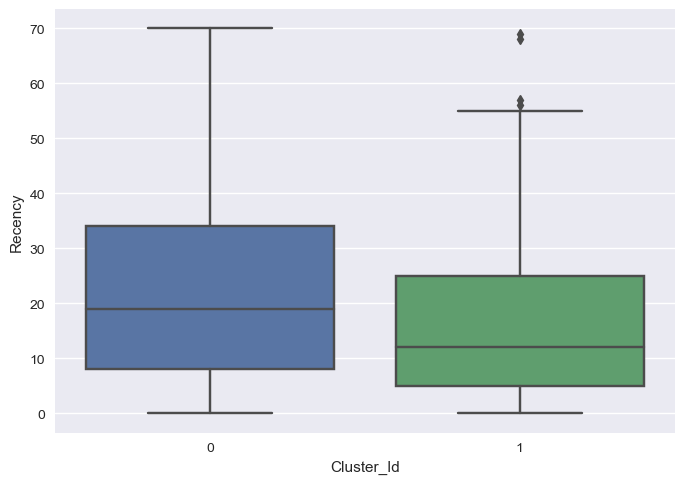

In [217]:
# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=df)

In [218]:
df.head()

Customer_ID    Customer_Name      Segment       Amount  Orders  Purchases  \
2          590  Patrick O'Brill     Consumer  26707.45620     102         45   
3          295       Gary Hwang     Consumer  24625.59300     102         41   
4           89      Bill Eplett  Home Office  28479.16740     102         42   
5          323     Harry Greene     Consumer  24216.45252     101         39   
6          264     Eric Murdock     Consumer  28084.40348     100         45   

   Frequency  Recency  _filter  Cluster_Id  
2  32.522727      4.0        0           1  
3  35.450000     18.0        0           1  
4  32.268293     35.0        0           1  
5  35.000000     12.0        0           1  
6  32.909091      2.0        0           1

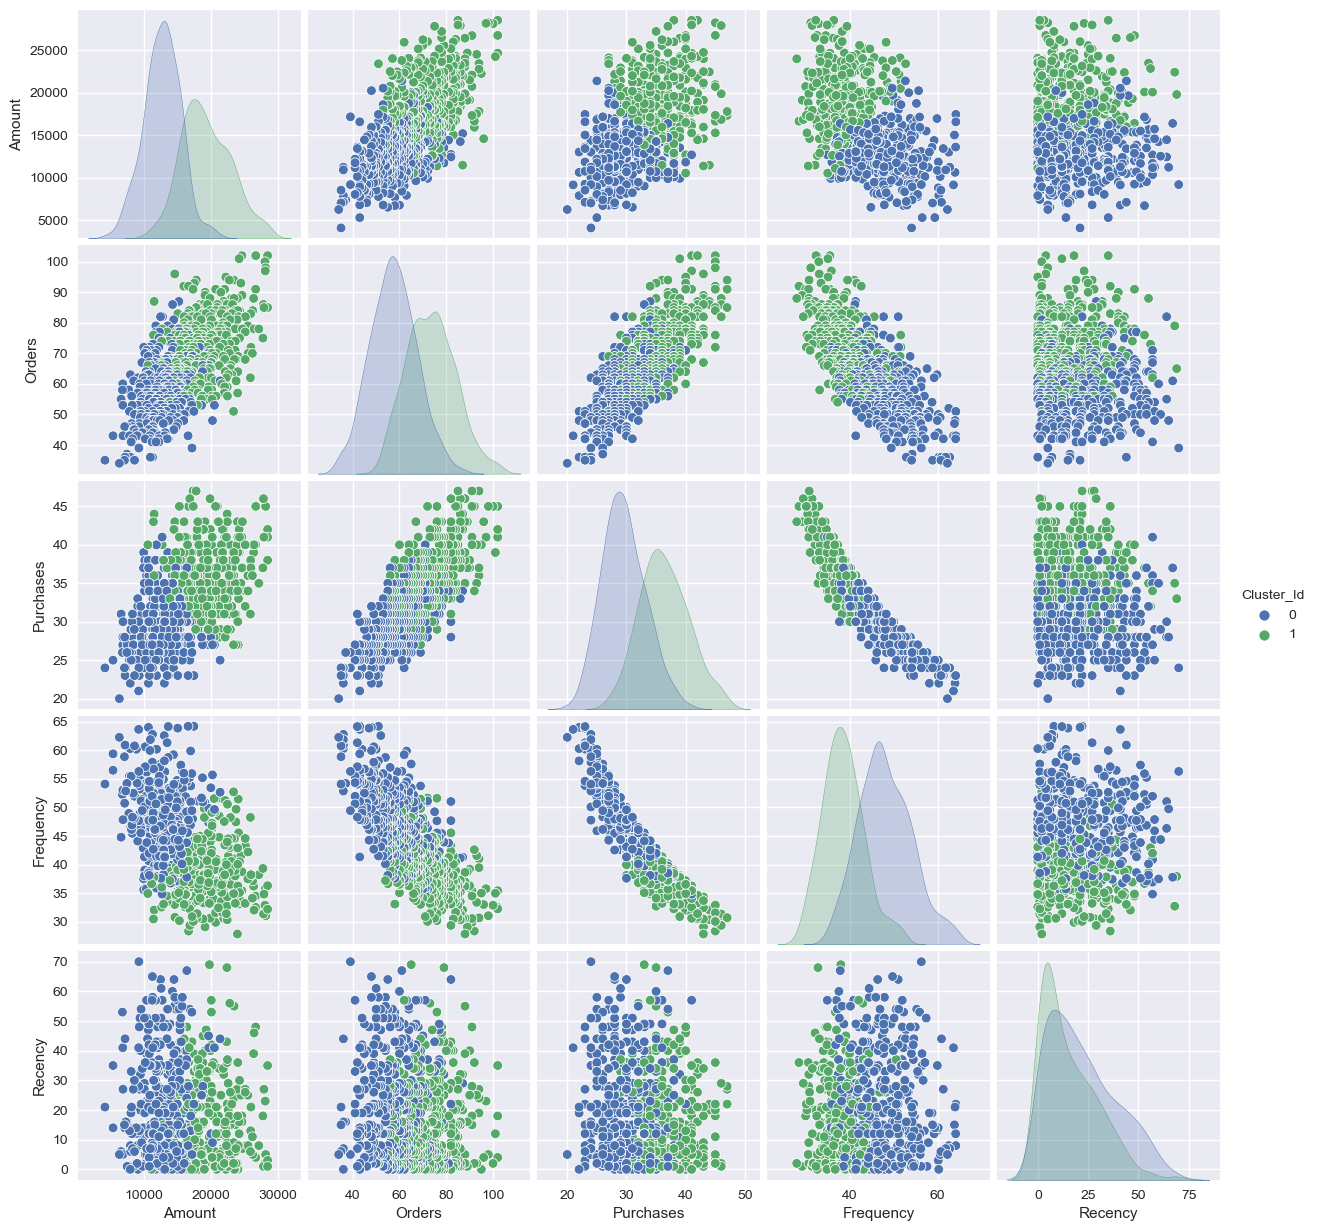

In [219]:
sns.pairplot(df[["Amount", "Orders", "Purchases", "Frequency", "Recency", "Cluster_Id"]],hue="Cluster_Id")

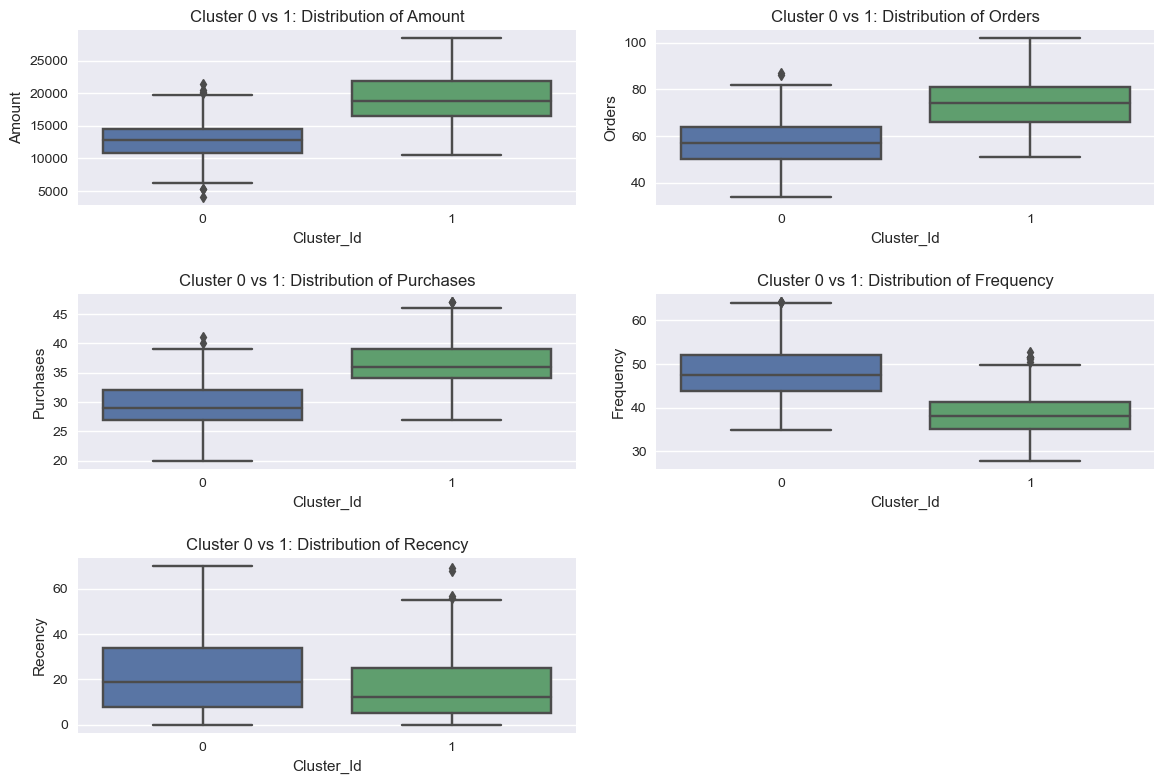

In [220]:
plt.figure(figsize=(12,8))
for index,i in enumerate(df[["Amount", "Orders", "Purchases", "Frequency", "Recency"]]):
    plt.subplot(3,2,index+1)
    plt.tight_layout(pad=2,h_pad=2)
    plt.title(f"Cluster 0 vs 1: Distribution of {i}")
    sns.boxplot(y=df[i],x=df.Cluster_Id)

In [221]:
for i in df.Cluster_Id.drop_duplicates():
    display(df[df.Cluster_Id==i].describe())


Customer_ID        Amount      Orders   Purchases   Frequency  \
count   333.000000    333.000000  333.000000  333.000000  333.000000   
mean    398.087087  19270.591398   73.468468   36.399399   38.492097   
std     227.574207   3676.988206   10.314471    4.125253    4.728390   
min       1.000000  10548.057000   51.000000   27.000000   27.880952   
25%     203.000000  16545.256180   66.000000   34.000000   35.157895   
50%     402.000000  18766.156600   74.000000   36.000000   38.181818   
75%     585.000000  21942.849600   81.000000   39.000000   41.250000   
max     794.000000  28479.992260  102.000000   47.000000   52.730769   

          Recency  _filter  Cluster_Id  
count  333.000000    333.0       333.0  
mean    15.567568      0.0         1.0  
std     13.826129      0.0         0.0  
min      0.000000      0.0         1.0  
25%      5.000000      0.0         1.0  
50%     12.000000      0.0         1.0  
75%     25.000000      0.0         1.0  
max     69.000000      0.0         1.0

Customer_ID        Amount      Orders   Purchases   Frequency  \
count   392.000000    392.000000  392.000000  392.000000  392.000000   
mean    382.492347  12667.581276   57.403061   29.522959   48.102799   
std     229.570532   2765.858995    9.797739    3.655845    6.009224   
min       3.000000   4115.208000   34.000000   20.000000   34.850000   
25%     178.750000  10869.092380   50.000000   27.000000   43.893750   
50%     371.000000  12829.391000   57.000000   29.000000   47.561576   
75%     579.250000  14512.319850   64.000000   32.000000   51.961538   
max     795.000000  21365.942000   87.000000   41.000000   64.181818   

          Recency  _filter  Cluster_Id  
count  392.000000    392.0       392.0  
mean    22.137755      0.0         0.0  
std     16.812990      0.0         0.0  
min      0.000000      0.0         0.0  
25%      8.000000      0.0         0.0  
50%     19.000000      0.0         0.0  
75%     34.000000      0.0         0.0  
max     70.000000      0.0         0.0

## Consider more parameters (optional)
The above analysis is elementary: it only considers 3 elements of a dataset that contains a lot of information.

Try to think about other parameters that you could consider in the analysis that makes sense. For example: Are there any perceivable differences in behavior between Corporate and Consumer Segments? Could you deduce patterns between the product categories? Are there any noteworthy differences between the states?

In [222]:
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode()

plotly.offline.init_notebook_mode()

fig = px.scatter_3d(df, x="Amount", y="Frequency", z="Recency", color='Cluster_Id')
fig.update_layout(autosize = True, width = 1000, height = 500)
plotly.offline.iplot(fig, filename='simple-3d-scatter')